# Hospital Readmission due to Diabetes - Decision Tree Classification

This data set is made available by the Center for Clinical and Translational Research, Virginia Commonwealth University. It contains data about 10 years of clinical care at 130 US Hospitals. Each row represents a single patient. The columns include the characteristics of deidentified diabetes patients. This is a binary classification task: predict whether a diabetes patient is readmitted to the hospital within 30 days of their discharge (1=Yes, 0=No). This is an important performance metric for hospitals as they try to minimize these types of readmissions.

## Description of Variables

The description of variables are provided in "Healthcare - Data Dictionary.docx"

## Goal

Use the **healthcare.csv** data set and build a model to predict **readmitted**.

# Read and Prepare the Data
## feature engineering: create one new variable from existing ones

### Setup 

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)

In [2]:

healthcare = pd.read_csv("healthcare.csv")
healthcare.head()

,race,gender,age,admission_type,discharge_disposition,admission_source,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed,readmitted
0,Other,Female,70-80,2,3,1,14,NaN,InternalMedicine,32,...,486,404,428,9,None,None,No,No,No,1
1,Caucasian,Female,80-90,1,3,5,4,MC,NaN,44,...,38,438,599,9,None,None,Steady,Ch,Yes,0
2,AfricanAmerican,Male,50-60,5,1,1,6,HM,NaN,29,...,296,585,428,9,None,None,Up,Ch,Yes,1
3,Caucasian,Female,50-60,1,1,6,3,HM,InternalMedicine,47,...,250.02,401,493,4,None,>8,No,Ch,Yes,0
4,AfricanAmerican,Female,40-50,3,1,1,4,UN,Hematology,92,...,486,287,595,7,None,>7,No,No,No,0


### Split data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(healthcare, test_size=0.3)

### Check missing values

In [4]:
train_set.isna().sum()

race                      114
gender                      0
age                         0
admission_type              0
discharge_disposition       0
admission_source            0
time_in_hospital            0
payer_code               2492
medical_specialty        3043
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      3
diag_2                     12
diag_3                     62
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
dtype: int64

In [5]:
test_set.isna().sum()

race                       60
gender                      0
age                         0
admission_type              0
discharge_disposition       0
admission_source            0
time_in_hospital            0
payer_code               1032
medical_specialty        1306
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      8
diag_3                     36
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
dtype: int64

### Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

### Separate the target variables 

In [7]:
train_y = train_set['readmitted']
test_y = test_set['readmitted']

train_inputs = train_set.drop(['readmitted'], axis=1)
test_inputs = test_set.drop(['readmitted'], axis=1)

### Feature Engineering: Derive new column

In [8]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['A1cTestDone'] = np.where(df1['A1Cresult'] == 'None', 0, 1)
    ##df1['ChancesofReadmission'] = np.where(df1['diag_1'] != 'V58', 0, 1)
    return df1[['A1cTestDone']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

In [9]:
#Let's test the new function:

# create a new dataframe from the column we need for the calculation
subset_df = train_set[['A1Cresult']]

# Send the new dataframe to the function we created
new_col(subset_df)

,A1cTestDone
4166,1
5546,0
2957,0
6329,1
565,0
...,...
5734,0
5191,0
5390,0
860,0


### Identify numerical and categorical variables 

In [10]:
train_inputs.dtypes

race                     object
gender                   object
age                      object
admission_type            int64
discharge_disposition     int64
admission_source          int64
time_in_hospital          int64
payer_code               object
medical_specialty        object
num_lab_procedures        int64
num_procedures            int64
num_medications           int64
number_outpatient         int64
number_emergency          int64
number_inpatient          int64
diag_1                   object
diag_2                   object
diag_3                   object
number_diagnoses          int64
max_glu_serum            object
A1Cresult                object
insulin                  object
change                   object
diabetesMed              object
dtype: object

In [11]:
train_inputs['admission_source']= train_inputs['admission_source'].astype('object')
train_inputs['admission_type']= train_inputs['admission_type'].astype('object')
train_inputs['discharge_disposition']= train_inputs['discharge_disposition'].astype('object')


# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [12]:
# Identify the binary columns so we can pass them through without transforming


In [13]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

#for col in binary_columns:
 #   numeric_columns.remove(col)

In [14]:
categorical_columns

['race',
 'gender',
 'age',
 'admission_type',
 'discharge_disposition',
 'admission_source',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'insulin',
 'change',
 'diabetesMed']

In [15]:
numeric_columns

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [16]:
transformed_columns = ['A1Cresult']

### Pipeline

In [17]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [18]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [20]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col))])

In [21]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        #('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, transformed_columns)
],
        remainder='passthrough')

### Transform: fit_transform() for TRAIN

In [22]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

<6066x1322 sparse matrix of type '<class 'numpy.float64'>'
	with 146540 stored elements in Compressed Sparse Row format>

### Tranform: transform() for TEST

In [23]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

<2600x1322 sparse matrix of type '<class 'numpy.float64'>'
	with 62668 stored elements in Compressed Sparse Row format>

In [24]:
test_x.shape

(2600, 1322)

# Baseline:

In [25]:
train_y.value_counts()/len(train_y)

0    0.531322
1    0.468678
Name: readmitted, dtype: float64

## Decision Tree Model 1

In [26]:
from sklearn.tree import DecisionTreeClassifier ##without parameters performs best--not always usually it overfits

tree_clf = DecisionTreeClassifier(min_samples_leaf=10)
#tree_clf = DecisionTreeClassifier()

tree_clf.fit(train_x, train_y)

DecisionTreeClassifier(min_samples_leaf=10)

### Accuracy

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
#Train accuracy:
train_y_pred = tree_clf.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.7515661061655127


In [29]:
#Test accuracy:
test_y_pred = tree_clf.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

##little overfitting

0.5603846153846154


### Classification Matrix

In [30]:
from sklearn.metrics import confusion_matrix

#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[863, 532],
       [611, 594]], dtype=int64)

### Classification Report

In [31]:
from sklearn.metrics import classification_report

print(classification_report(test_y, test_y_pred))

              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1395
           1       0.53      0.49      0.51      1205

    accuracy                           0.56      2600
   macro avg       0.56      0.56      0.56      2600
weighted avg       0.56      0.56      0.56      2600



# Decision Tree Model 2:

In [32]:
#tree_clf2 = DecisionTreeClassifier(min_samples_leaf = 10, max_depth=10,criterion='entropy')
tree_clf2 = DecisionTreeClassifier(min_samples_leaf =15,criterion='entropy')
tree_clf2.fit(train_x, train_y)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=15)

In [33]:
#Train accuracy:
train_y_pred = tree_clf2.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.7276623804813716


In [34]:
#Test accuracy:
test_y_pred = tree_clf2.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.5573076923076923


In [35]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[869, 526],
       [625, 580]], dtype=int64)

## Decision Tree Model 3:

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {'max_depth': randint(low=5, high=20), 
              'min_samples_leaf': randint(low=5, high=20)}

tree_gs = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, 
                             n_iter=15, cv=5, verbose=1,
                             scoring='accuracy',
                             return_train_score=True)

tree_gs.fit(train_x, train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=15,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A55D392EE0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A55D392FA0>},
                   return_train_score=True, scoring='accuracy', verbose=1)

In [37]:
cvres = tree_gs.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.5731955164466223 {'max_depth': 19, 'min_samples_leaf': 9}
0.6028708757814506 {'max_depth': 10, 'min_samples_leaf': 13}
0.5916622639690013 {'max_depth': 14, 'min_samples_leaf': 12}
0.5966048749747042 {'max_depth': 6, 'min_samples_leaf': 5}
0.5980881200503605 {'max_depth': 6, 'min_samples_leaf': 11}
0.5980896140248896 {'max_depth': 8, 'min_samples_leaf': 14}
0.5926469289995395 {'max_depth': 9, 'min_samples_leaf': 16}
0.5984199182116854 {'max_depth': 11, 'min_samples_leaf': 7}
0.589679895584762 {'max_depth': 14, 'min_samples_leaf': 6}
0.578308576364508 {'max_depth': 17, 'min_samples_leaf': 11}
0.5947905108170547 {'max_depth': 9, 'min_samples_leaf': 18}
0.5689101184178538 {'max_depth': 19, 'min_samples_leaf': 5}
0.6068278710455512 {'max_depth': 5, 'min_samples_leaf': 13}
0.5964398586971728 {'max_depth': 9, 'min_samples_leaf': 5}
0.5982550377500201 {'max_depth': 11, 'min_samples_leaf': 13}


In [38]:
#Find the best parameter set
tree_gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 13}

In [39]:
tree_gs.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=13)

### Find feature importance and plot them

In [40]:
importance=tree_gs.best_estimator_.feature_importances_

In [41]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00038
Feature: 1, Score: 0.00368
Feature: 2, Score: 0.00879
Feature: 3, Score: 0.01341
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00276
Feature: 6, Score: 0.55892
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00894
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.01017
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.05469
Fe

In [42]:
from matplotlib import pyplot

<BarContainer object of 1322 artists>

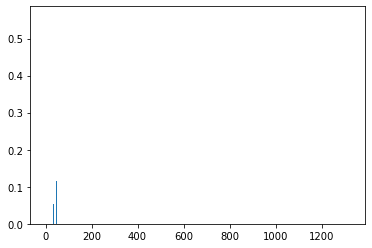

In [43]:
pyplot.bar([x for x in range(len(importance))], importance)

In [44]:
pyplot.show()

### Train accuracy

In [45]:
#Train accuracy:
train_y_pred = tree_gs.best_estimator_.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.6231454005934718


### Test accuracy 

In [46]:
#Test accuracy:
test_y_pred = tree_gs.best_estimator_.predict(test_x)

print(accuracy_score(test_y, test_y_pred))##best model can be

0.6080769230769231


In [47]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[925, 470],
       [549, 656]], dtype=int64)

# Discussion
 
1) Which model performs the best (and why)?<br>
2) Does the best model perform better than the baseline (and why)?<br>
3) Does the best model exhibit any overfitting; what did you do about it?

1)Decision Tree Model 3 with best estimators for random grid search performs best with test accuracy of 61% higher than other models. 
2)The best model performs better than baseline model(accuracy=53%) with accuracy of 61%.
3)The best model does not exhibit any overfitting.

## Extra

In [48]:
healthcare_competition = pd.read_csv("healthcare_competition.csv")

In [50]:
PatientID=healthcare_competition['patient_id']

In [51]:
healthcare_competition=healthcare_competition.drop(['patient_id'],axis=1)

In [52]:
subset_df = healthcare_competition[['A1Cresult']]

# Send the new dataframe to the function we created
new_col(subset_df)

,A1cTestDone
0,0
1,0
2,0
3,0
4,0
...,...
495,0
496,0
497,1
498,0


In [53]:
healthcare_competition.dtypes

race                     object
gender                   object
age                      object
admission_type            int64
discharge_disposition     int64
admission_source          int64
time_in_hospital          int64
payer_code               object
medical_specialty        object
num_lab_procedures        int64
num_procedures            int64
num_medications           int64
number_outpatient         int64
number_emergency          int64
number_inpatient          int64
diag_1                   object
diag_2                   object
diag_3                   object
number_diagnoses          int64
max_glu_serum            object
A1Cresult                object
insulin                  object
change                   object
diabetesMed              object
dtype: object

In [54]:
# Transform the test data
testhealth = preprocessor.transform(healthcare_competition)

testhealth

<500x1322 sparse matrix of type '<class 'numpy.float64'>'
	with 12040 stored elements in Compressed Sparse Row format>

In [55]:

bestprediction = tree_gs.best_estimator_.predict(testhealth)


In [56]:
bestpredictiondf=pd.DataFrame(bestprediction,columns=['Readmitted'])

In [57]:
#bestprediction=np.append(bestprediction, Result)
#bestprediction=np.reshape(bestprediction, Result)
bestpredictiondf.insert(1, "ID", np.arange(1, 501, 1).tolist(), False)

In [58]:
bestpredictiondf.head()

,Readmitted,ID
0,0,1
1,1,2
2,0,3
3,0,4
4,0,5


In [59]:
bestpredictiondf.to_csv('salian_dt_competition.csv',index=False)

In [60]:
bestprediction.shape

(500,)